In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import sys
sys.path.append('/content/drive/MyDrive')

In [38]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, matthews_corrcoef

# from helper_functions import Classification_eval, eval_metrics, plot_shap_summary_and_importance
from helper_functions import *

seed = 1234
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [17]:
schema = {'Unnamed: 0':'int32',
'step':'int32',
'amount':'float32',
'nameOrig':'object',
'oldbalanceOrig':'float32',
'newbalanceOrig':'float32',
'nameDest':'object',
'oldbalanceDest':'float32',
'newbalanceDest':'float32',
'isFraud':'int32',
'isFlaggedFraud':'int32',
'merchOrig':'int32',
'merchDest':'int32',
'merchInvolved':'int32',
'origBalanceCleared':'int32',
'amount_eq_bal':'int32',
'prev_orig_steps_num':'float32',
'prev_orig_avg_amount':'float32',
'prev_orig_fraud_max':'float32',
'prev_orig_txn_hour_avg':'float32',
'prev_orig_merchInvolved_total':'float32',
'prev_orig_merch_orig_sum':'float32',
'prev_orig_merchDest_sum':'float32',
'prev_dest_steps_num':'float32',
'prev_dest_avg_amount':'float32',
'prev_dest_fraud_max':'float32',
'prev_dest_txn_hour_avg':'float32',
'prev_dest_merchInvolved_total':'float32',
'prev_dest_merch_orig_sum':'float32',
'prev_dest_merchDest_sum':'float32',
'log_oldbalanceOrig':'float32',
'log_newbalanceOrig':'float32',
'log_oldbalanceDest':'float32',
'log_newbalanceDest':'float32',
'log_amount':'float32',
'log_prev_orig_avg_amount':'float32',
'log_prev_dest_avg_amount':'float32',
'hour_diff_orig':'int32',
'hour_diff_dest':'int32',
'amt_diff_orig':'float32',
'amt_diff_dest':'float32',
'missingindicator_prev_orig_steps_num':'int32',
'missingindicator_prev_orig_avg_amount':'int32',
'missingindicator_prev_orig_fraud_max':'int32',
'missingindicator_prev_orig_txn_hour_avg':'int32',
'missingindicator_prev_orig_merchInvolved_total':'int32',
'missingindicator_prev_orig_merch_orig_sum':'int32',
'missingindicator_prev_orig_merchDest_sum':'int32',
'missingindicator_prev_dest_steps_num':'int32',
'missingindicator_prev_dest_avg_amount':'int32',
'missingindicator_prev_dest_fraud_max':'int32',
'missingindicator_prev_dest_txn_hour_avg':'int32',
'missingindicator_prev_dest_merchInvolved_total':'int32',
'missingindicator_prev_dest_merch_orig_sum':'int32',
'missingindicator_prev_dest_merchDest_sum':'int32',
'missingindicator_log_prev_orig_avg_amount':'int32',
'missingindicator_log_prev_dest_avg_amount':'int32',
'missingindicator_hour_diff_orig':'int32',
'missingindicator_hour_diff_dest':'int32',
'missingindicator_amt_diff_orig':'int32',
'missingindicator_amt_diff_dest':'int32',
'txn_hour_1':'int32',
'txn_hour_2':'int32',
'txn_hour_3':'int32',
'txn_hour_4':'int32',
'txn_hour_5':'int32',
'txn_hour_6':'int32',
'txn_hour_7':'int32',
'txn_hour_8':'int32',
'txn_hour_9':'int32',
'txn_hour_10':'int32',
'txn_hour_11':'int32',
'txn_hour_12':'int32',
'txn_hour_13':'int32',
'txn_hour_14':'int32',
'txn_hour_15':'int32',
'txn_hour_16':'int32',
'txn_hour_17':'int32',
'txn_hour_18':'int32',
'txn_hour_19':'int32',
'txn_hour_20':'int32',
'txn_hour_21':'int32',
'txn_hour_22':'int32',
'txn_hour_23':'int32',
'type_CASH_OUT':'int32',
'type_DEBIT':'int32',
'type_PAYMENT':'int32',
'type_TRANSFER':'int32'

}

In [18]:
train = pd.read_csv('/content/drive/MyDrive/Data/Paysim Fraud Detection/paysim_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/Paysim Fraud Detection/paysim_test.csv')

In [19]:
# Convert the datatypes according to the schema, to enable less resource usage
train = train.astype(schema)
test = test.astype(schema)

In [20]:
train.head()

,Unnamed: 0,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,157,"5,530.25",C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.62,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,260,"110,352.76",C1412043435,0.00,0.00,C41698878,"2,574,547.00","2,684,899.75",0,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,"300,834.84",0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0.00,12.61,0,4,0.00,"-190,482.09",1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,2,44,"5,406.11",C450614947,"81,630.00","76,223.89",M691104477,0.00,0.00,0,0,0,1,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.31,11.24,0.00,0.00,8.60,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,3,350,"8,221.22",C1796508227,"3,697.00",0.00,M1692201305,0.00,0.00,0,0,0,1,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.22,0.00,0.00,0.00,9.01,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,238,"7,787.64",C381041925,"82,938.00","75,150.36",M382945339,0.00,0.00,0,0,0,1,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.33,11.23,0.00,0.00,8.96,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [41]:
all_columns_fit = [col for col in train.columns if col not in ['step',
                                                               'isFraud', 'isFlaggedFraud', 'nameOrig',
                                                               'nameDest', 'Unnamed: 0'
                                                               ,'amount'
                                                               ,'oldbalanceOrig',
                                                                'newbalanceOrig',
                                                                'oldbalanceDest',
                                                                'newbalanceDest'
                                                                ,'prev_orig_avg_amount'
                                                                ,'prev_dest_avg_amount',

              # The balance features are not appropriate to perform supervised modeling on, since there are
#              issues when they were flagged as being fraudulent
                                                                'origBalanceCleared',
                                                                'log_oldbalanceOrig',
                                                                'log_newbalanceOrig',
                                                                'log_oldbalanceDest',
                                                                'log_newbalanceDest',
                                                                'amount_eq_bal'
                                                                ]]
all_columns_fit

['merchOrig',
 'merchDest',
 'merchInvolved',
 'prev_orig_steps_num',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchInvolved_total',
 'prev_orig_merch_orig_sum',
 'prev_orig_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchInvolved_total',
 'prev_dest_merch_orig_sum',
 'prev_dest_merchDest_sum',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'missingindicator_prev_orig_steps_num',
 'missingindicator_prev_orig_avg_amount',
 'missingindicator_prev_orig_fraud_max',
 'missingindicator_prev_orig_txn_hour_avg',
 'missingindicator_prev_orig_merchInvolved_total',
 'missingindicator_prev_orig_merch_orig_sum',
 'missingindicator_prev_orig_merchDest_sum',
 'missingindicator_prev_dest_steps_num',
 'missingindicator_prev_dest_avg_amount',
 'missingindicator_prev_dest_fraud_max',
 'missingindicator_prev_dest_txn_hour_avg

In [86]:
# Define hyperparamaters to search
# I cast a wide net on the hyperparamaters, since I am using Randomized search

# Define the parameter grid to search
scale = len(train['isFraud']) / (train['isFraud'].sum())

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [ 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0,0.05,  0.1, 0.2],
    'min_child_weight': [1, 2, 3, 4, 5],
    'scale_pos_weight': [1,scale]
}


xgb_clf = xgb.XGBClassifier(
                            random_state =seed,
                            objective='binary:logistic'
                            )

# Setup the RandomizedSearchCV
# randomized search is conducted, to reduce compute resources, although a full grid search
# will return the best results in the search space
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled
    scoring=['f1', 'recall','average_precision'],  # Metric used for evaluation, since it is a very imbalanced set, we use the AUPRC
    cv=4,  # Number of cross-validation folds
    verbose=3,
    random_state=seed,
    n_jobs=-1,
    refit='average_precision'
)


In [44]:
%%time
random_search_fit = random_search.fit(train[all_columns_fit], train['isFraud'])

Fitting 4 folds for each of 30 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 12min 39s, sys: 16.8 s, total: 12min 56s
Wall time: 1h 17min 36s


In [79]:
%%time
random_search2 = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled
    scoring=['f1', 'recall'],  # Metric used for evaluation, since it is a very imbalanced set, we use the AUPRC
    cv=4,  # Number of cross-validation folds
    verbose=3,
    random_state=seed,
    n_jobs=-1,
    refit='recall'
)

random_search_fit2 = random_search2.fit(train[all_columns_fit], train['isFraud'])

Fitting 4 folds for each of 30 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 7min 41s, sys: 20.3 s, total: 8min 1s
Wall time: 1h 27min 37s


In [80]:
print("The best score identified is: ", random_search_fit2.best_score_)
print("The best parameters identified are: \n" ,random_search_fit2.best_params_)

The best score identified is:  0.8604863221884498
The best parameters identified are: 
 {'subsample': 1.0, 'scale_pos_weight': 773.570820668693, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


Investigate the best parameters selected

In [81]:
print("The best score identified is: ", random_search_fit.best_score_)
print("The best parameters identified are: \n" ,random_search_fit.best_params_)

The best score identified is:  0.4785566005982985
The best parameters identified are: 
 {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9}


From the selected hyperparamaters, we can see that the following hyperparameters were selected at the boundary of the search area provided.  This could indicate that a local optimum was reached, vs a global one.

* subsample: 1.0.  This was the value selected that indicates how many observations were sampled to train the tree, this could be an indication of overfitting of the model.
* scale_pos_weight: 1. A common approach is to use this to help the model converge faster to an optimum prediction.
* max_depth: 8.  Not too much of a concern, as the model will tend to go deeper to fit better.  This could be an indication of overfitting of the model.
* gamma: 0.5.  This is how conservative the algorithm will be and is a regularisation paramater applied.
* colsample_bytree: 1.0.  This is how many features were used in growing the tree, this could again be an indication of overfitting of the model to the training data.

In an ideal scenario, a new parameter distribution would be considered as per below, in an attempt to get closer to global optimums (along with using an exhaustive Grid Search and not a Randomized search).  The paramater distribution could be adjusted as below based on the values selected before, allowing for search around the optima that were selected.

However, the author notes that this might still not yield the global optima and a potentially infinite number of values need to be considered to reach that.

In [46]:
param_dist_2 = {
    'n_estimators': [200, 250, 300, 350, 400], # values around the previously selected one was added and others near the edges removed
     'max_depth': [ 5, 6, 7], # a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'learning_rate': [0.01, 0.03, 0.05, 0.06 , 0.1],
    'subsample': [ 0.9, 0.95, 0.99, 1], # adjusted around the value selected previously, removing the maximum value in an attempt to avoid overfitting
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95],# a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'gamma': [ 0.45, 0.5, 0.55], # adjusted to allow for finer selection of this regularization paramater
    'min_child_weight': [1, 2, 3, 4, 5], # values remained the same for this, as I would like to test whether underfitting would occur
    'scale_pos_weight': [1,scale] # remains the same as before aas only 2 values exist and want to examine the scaled version and normal version again
}


Model metrics Summary (train): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083516
           1       0.88      0.35      0.50      6580

    accuracy                           1.00   5090096
   macro avg       0.94      0.67      0.75   5090096
weighted avg       1.00      1.00      1.00   5090096

Model metrics Summary (test): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270891
           1       0.82      0.33      0.47      1633

    accuracy                           1.00   1272524
   macro avg       0.91      0.67      0.74   1272524
weighted avg       1.00      1.00      1.00   1272524



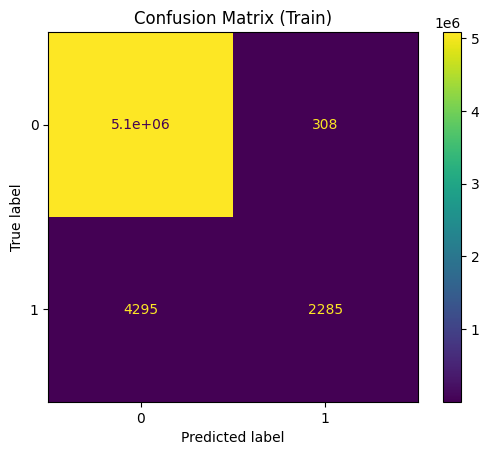

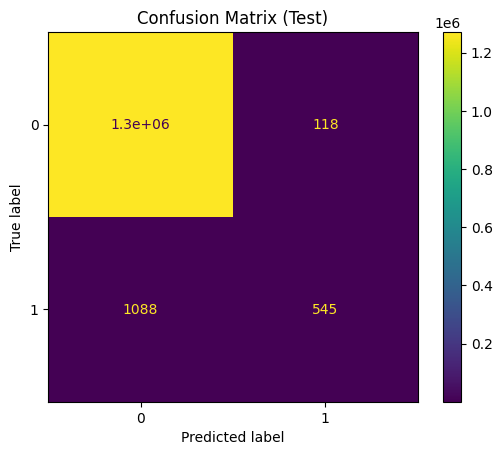

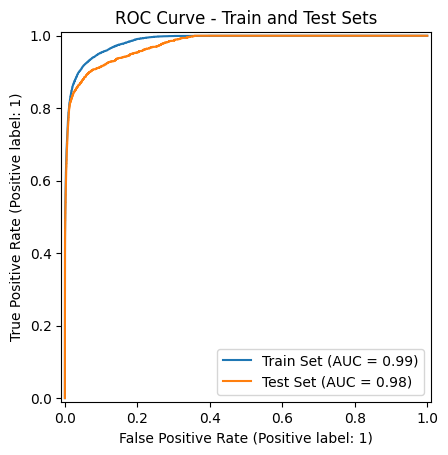

Model Lift Report (Train): 
%s    decile  response_rate   count  lift
0       1           0.01  508801  9.53
1       2           0.00  509218  0.37
2       3           0.00  509010  0.09
3       4           0.00  509009  0.01
4       5           0.00  509010  0.00
5       6           0.00  509009  0.00
6       7           0.00  508932  0.00
7       8           0.00  508613  0.00
8       9           0.00  508161  0.00
9      10           0.00  510333  0.00 

Model Lift Report (Test): 
%s    decile  response_rate   count  lift
0       1           0.01  127236  9.15
1       2           0.00  127269  0.39
2       3           0.00  127252  0.32
3       4           0.00  127253  0.14
4       5           0.00  127252  0.00
5       6           0.00  127252  0.00
6       7           0.00  127224  0.00
7       8           0.00  127226  0.00
8       9           0.00  126993  0.00
9      10           0.00  127567  0.00


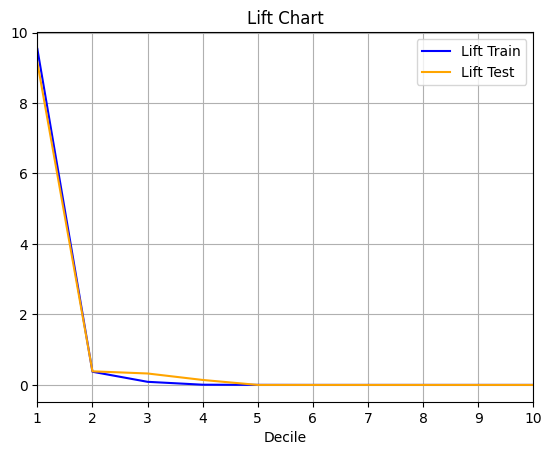

In [83]:
eval_metrics(random_search_fit,
             train[all_columns_fit],
             train['isFraud'],
             test[all_columns_fit],
             test['isFraud'])

The Area under Precision-Recall curve is more suitable in instances where the data is severely imbalanced, as in this case.  So I would like to generate that as well, and it is not in the general function definition of the helper funcitons I have created to evaluate metrics

In [67]:
y_pred_probs = random_search_fit.predict(test[all_columns_fit])

precision, recall, _ = precision_recall_curve( test['isFraud'], y_pred_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
average_precision = average_precision_score(test['isFraud'], y_pred_probs)

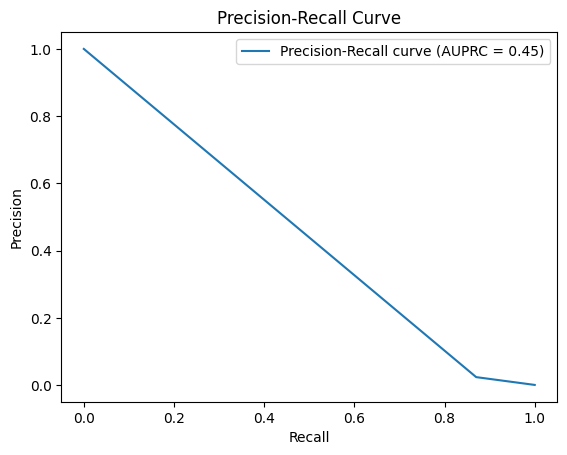

AUC-PR: 0.4473993247003465
Average Precision Score: 0.021446324606154418


In [68]:
# Plotting the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUPRC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

print(f"AUC-PR: {auc_pr}")
print(f"Average Precision Score: {average_precision}")

Due to the large class imbalance, the fit statistics indicate an almost perfectly performing model on the test dataset.  This could be coincidence, however it could also be valid performance.  Considering that this model has barely been tuned, more investigation is needed.

I start with investigating the Shapley values of the features, to see if there is a feature that could have caused some leaking

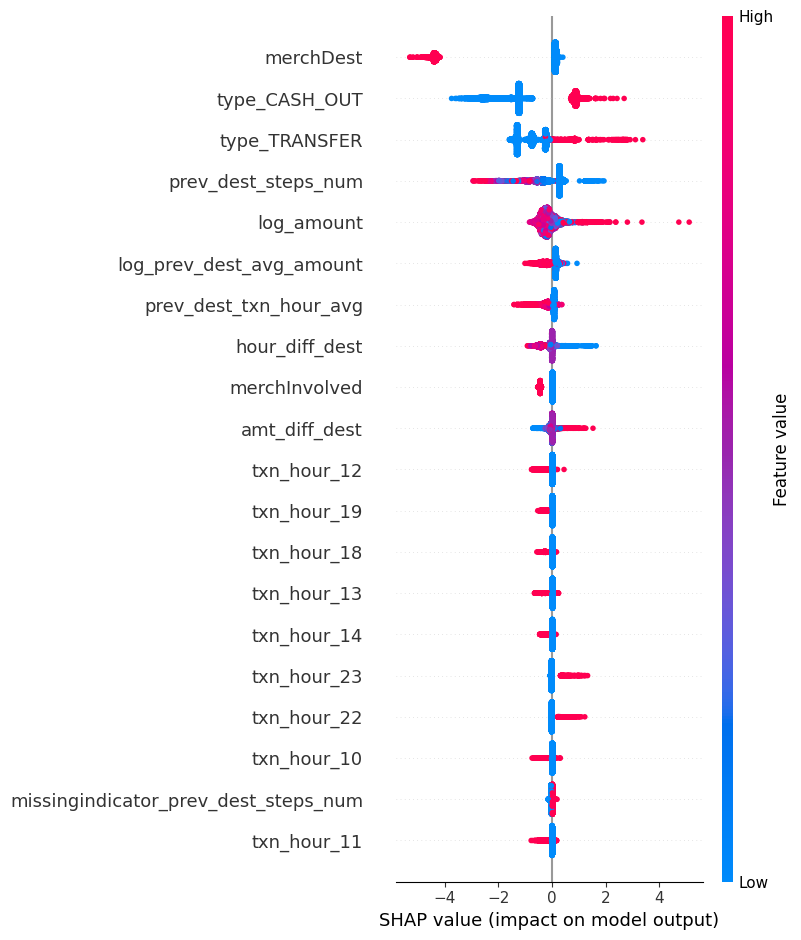

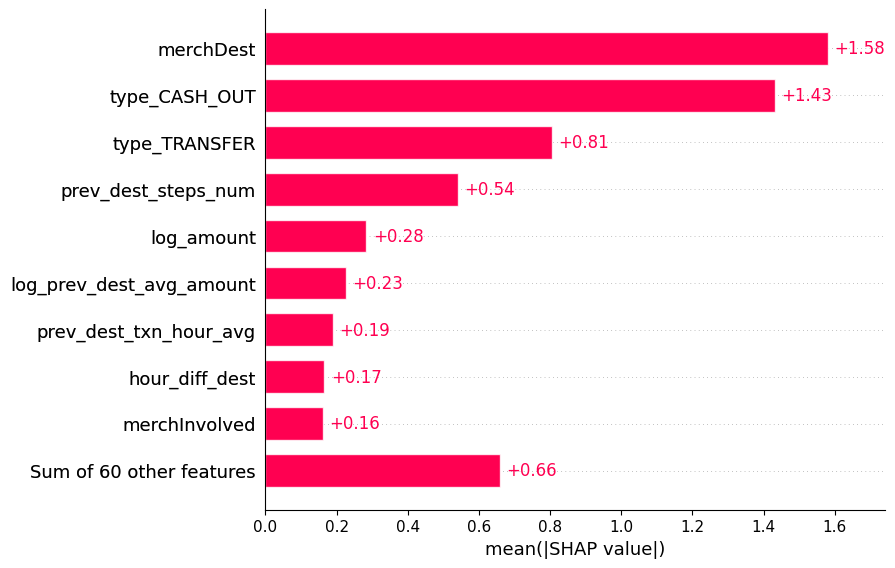

In [65]:
Classification_eval.plot_shap_summary_and_importance(random_search_fit.best_estimator_,
                                 test[all_columns_fit],
                                 max_display=20, random_state=seed)

***Whether or not the amount is equal to the entire balance (a created feature), is the most influential feature, along with the balance of the originating account

I will still do a correleation of each of the top 4 most predictive ones, along with target distribution between the training and test set

The distribution of targets in both are similar

In [ ]:
train[['isFraud','amount_eq_bal']].corr()

In [ ]:
train[['isFraud','amount_eq_bal']].groupby('isFraud').count()